# Problem Statement :
Given that power consumption data for the previous week, we have to predict the power consumption for the next week.

Dataset Description:
The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables
global_active_power: The total active power consumed by the household (kilowatts).
global_reactive_power: The total reactive power consumed by the household (kilowatts).
voltage: Average voltage (volts).
global_intensity: Average current intensity (amps).
sub_metering_1: Active energy for kitchen (watt-hours of active energy).
sub_metering_2: Active energy for laundry (watt-hours of active energy).
sub_metering_3: Active energy for climate control systems (watt-hours of active energy).
This data represents a multivariate time series of power-related variables that in turn could be used to model and even forecast future electricity consumption

Time-series predictions play a major role in machine learning which is often neglected. Nonetheless, there are lots of machine learning algorithms we could use for these problems. The major machine learning algorithms involving Statsmodels and Econometric models etc. Today we will take a look at how to use and apply Deep learning algorithms to predict the time series Data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Reading the dataset

data = pd.read_csv('household_power_consumption.txt', sep = ';',
                  parse_dates = True,
                  low_memory = False)

In [18]:
#printing top rows

data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [19]:
data['date_time'] = data['Date'].str.cat(data['Time'], sep= ' ')
data.drop(['Date', 'Time'], inplace= True, axis = 1)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [20]:
data.set_index(['date_time'], inplace=True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Next, we can mark all missing values indicated with a ‘?‘ character with a NaN value, which is a float.

In [21]:
#replacing each '?'characters with NaN value

data.replace('?', nan, inplace=True)

In [22]:
#This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)

data = data.astype('float')

In [23]:
#information of the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7+ MB


In [24]:
#checking the null values

np.isnan(data).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

We also need to fill in the missing values now that they have been marked.

A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill_missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [25]:
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row, col]):
                data[row, col] = data[row-one_day, col]

In [26]:
fill_missing(data.values)

In [27]:
#checking the nan values

np.isnan(data).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7+ MB


In [29]:
#printing the shape of the data

data.shape

(2075259, 7)

In [30]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
16/12/2006 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
16/12/2006 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
16/12/2006 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
16/12/2006 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Prepare power consumption for each day
We can now save the cleaned-up version of the dataset to a new file; in this case we will just change the file extension to .csv and save the dataset as ‘cleaned_data.csv‘.

In [31]:
#conversion of dataframe to .csv

data.to_csv('cleaned_data.csv')

In [32]:
#reading the dataset

dataset = pd.read_csv('cleaned_data.csv', parse_dates = True, index_col = 'date_time', low_memory = False)

In [33]:
#printing the top rows

dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [34]:
#printing the bottom rows

dataset.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


# Exploratory Data Analysis

In [35]:
#Downsampling the data into dáy-wise bins and sum the values of the timestamps falling into a bin.

data = dataset.resample('D').sum()

In [36]:
#data after sampling it into daywise manner

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [37]:
#Plotting the all features in various time stamps

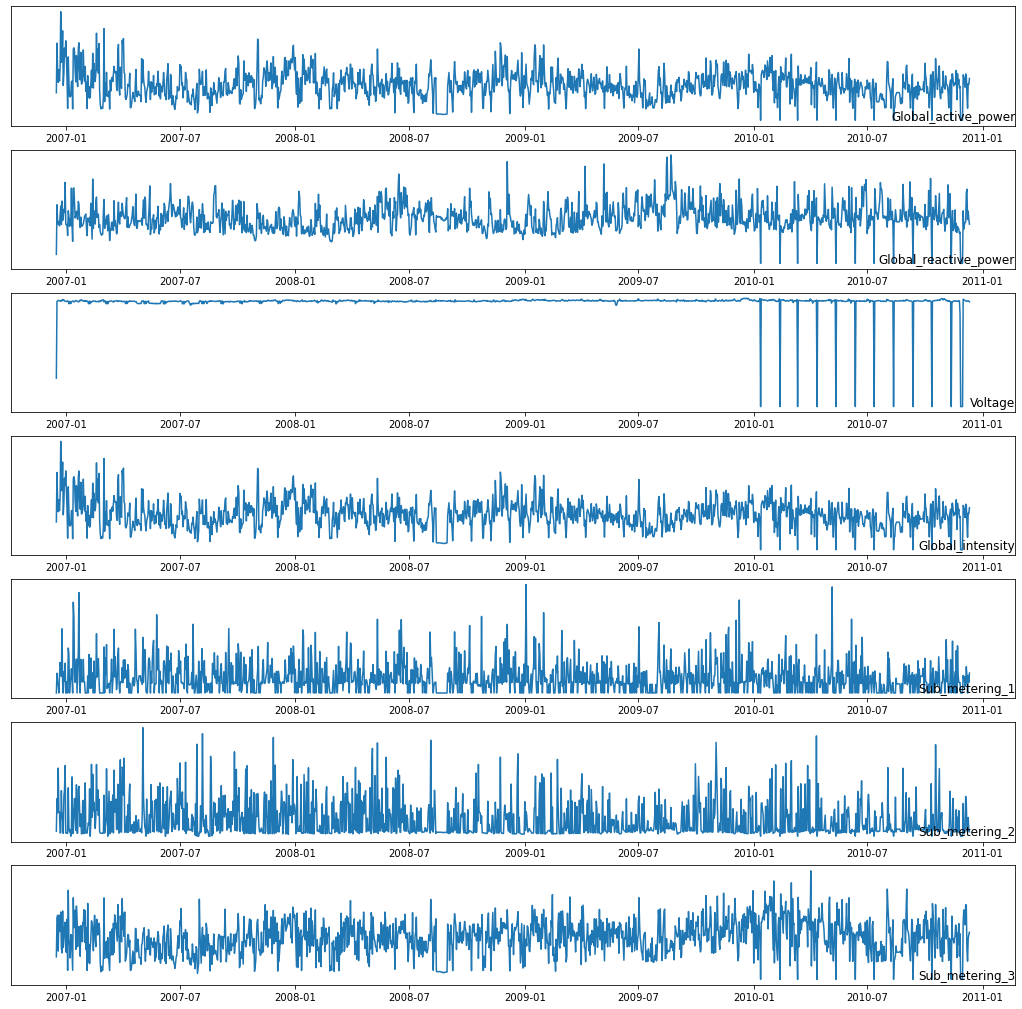

In [40]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

In [43]:
#Exploring Active power consumption for each year

In [45]:

#we have considered 5 years here

years = ['2007', '2008', '2009', '2010']

In [46]:
#Year wise plotting of feature Global_active_power

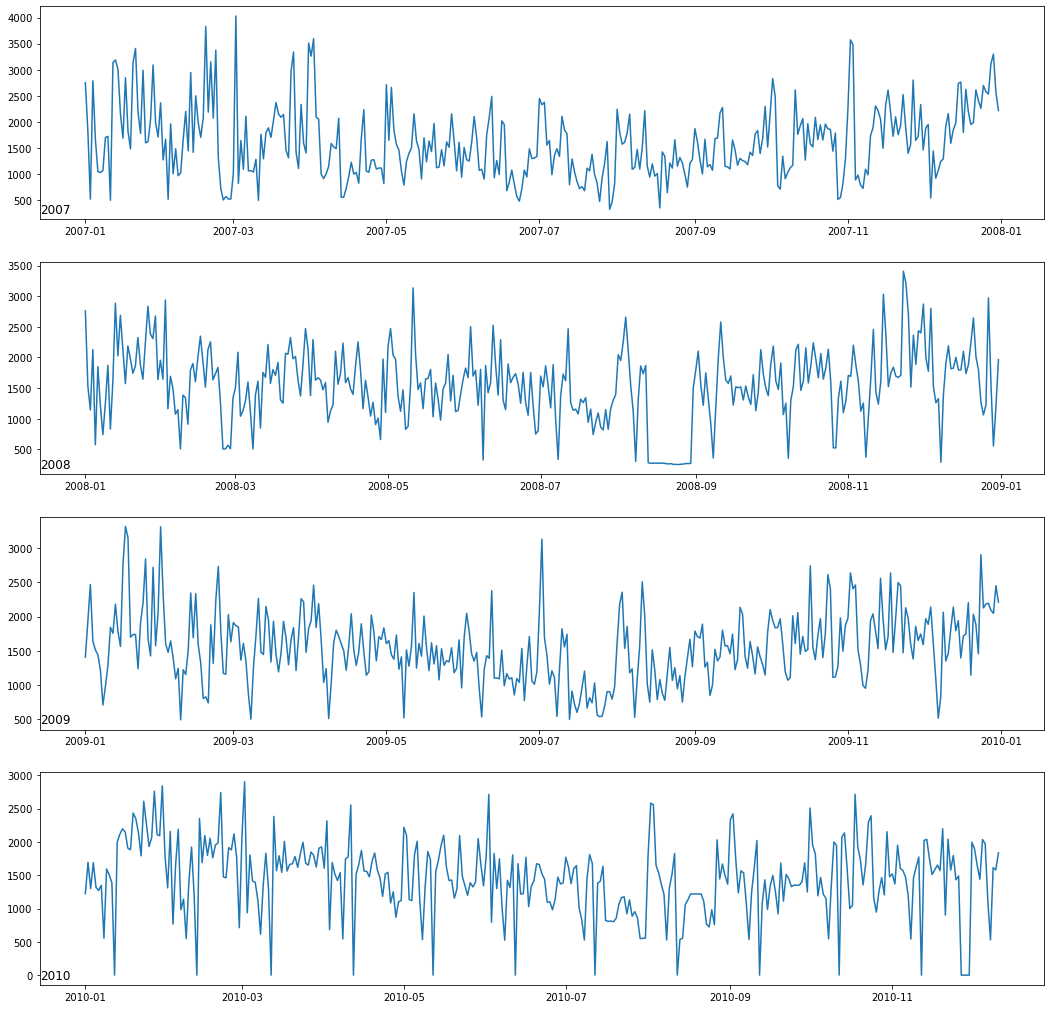

In [47]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data['Global_active_power'])
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

In [48]:
#for year 2006

data['2006']

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
2006-12-21,1723.288,144.434,347096.41,7266.4,1765.0,2692.0,10456.0
2006-12-22,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0
2006-12-23,4773.386,221.470,345795.95,20200.4,2669.0,425.0,14726.0
2006-12-24,2550.012,149.900,348029.91,11002.2,1703.0,5082.0,6891.0


Power consumption distribution with histogram
Year wise histogram plot of feature Global_active_power

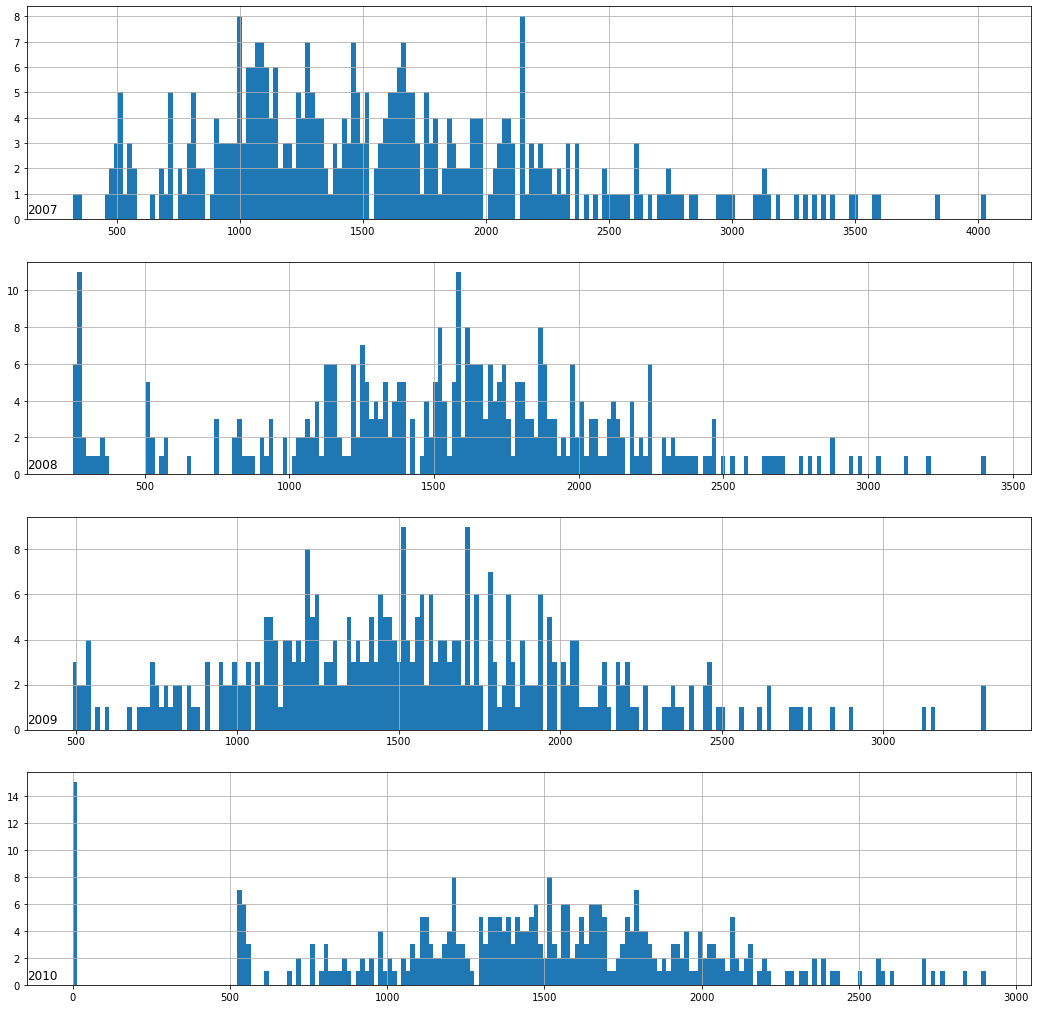

In [49]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    active_power_data['Global_active_power'].hist(bins = 200)
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

In [50]:
#Histogram plot for All Features

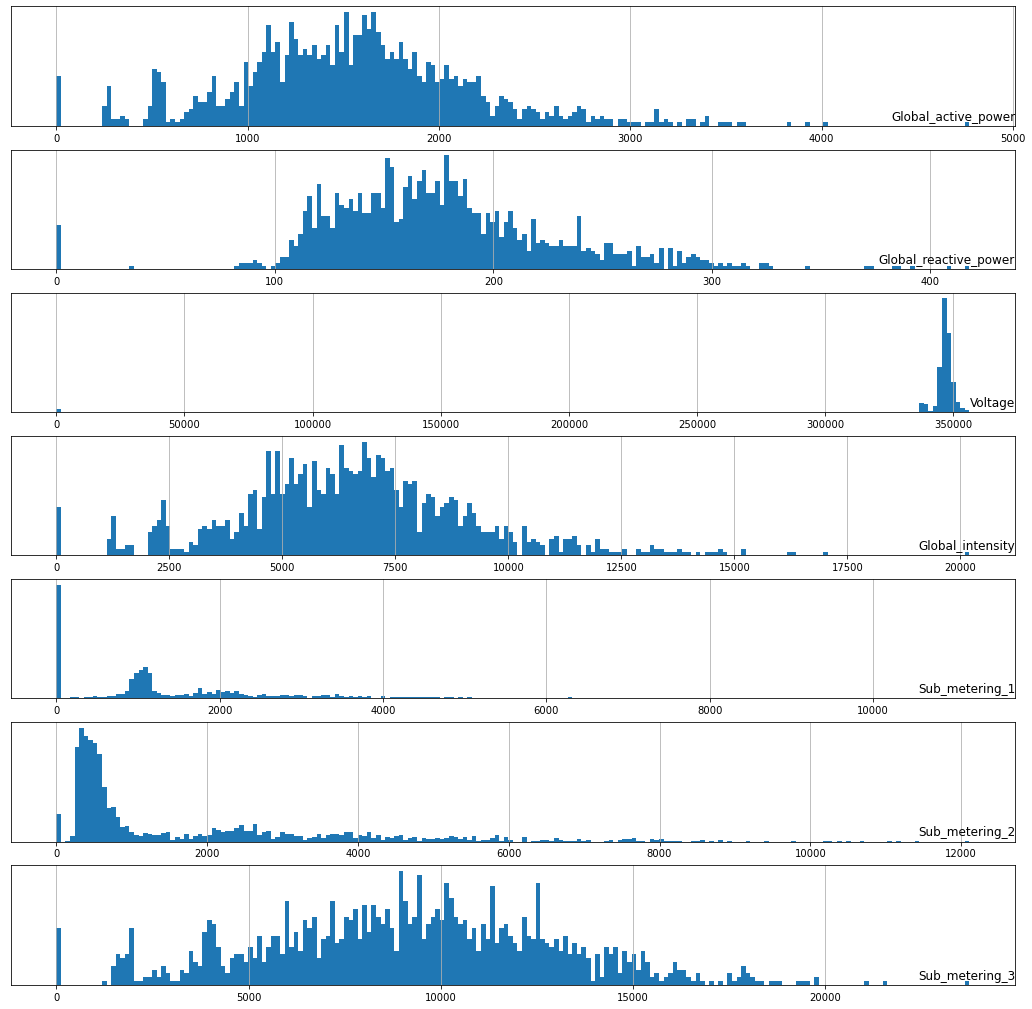

In [51]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    data[name].hist(bins=200)
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

In [52]:
#Plot power consumption hist for each month of 2007

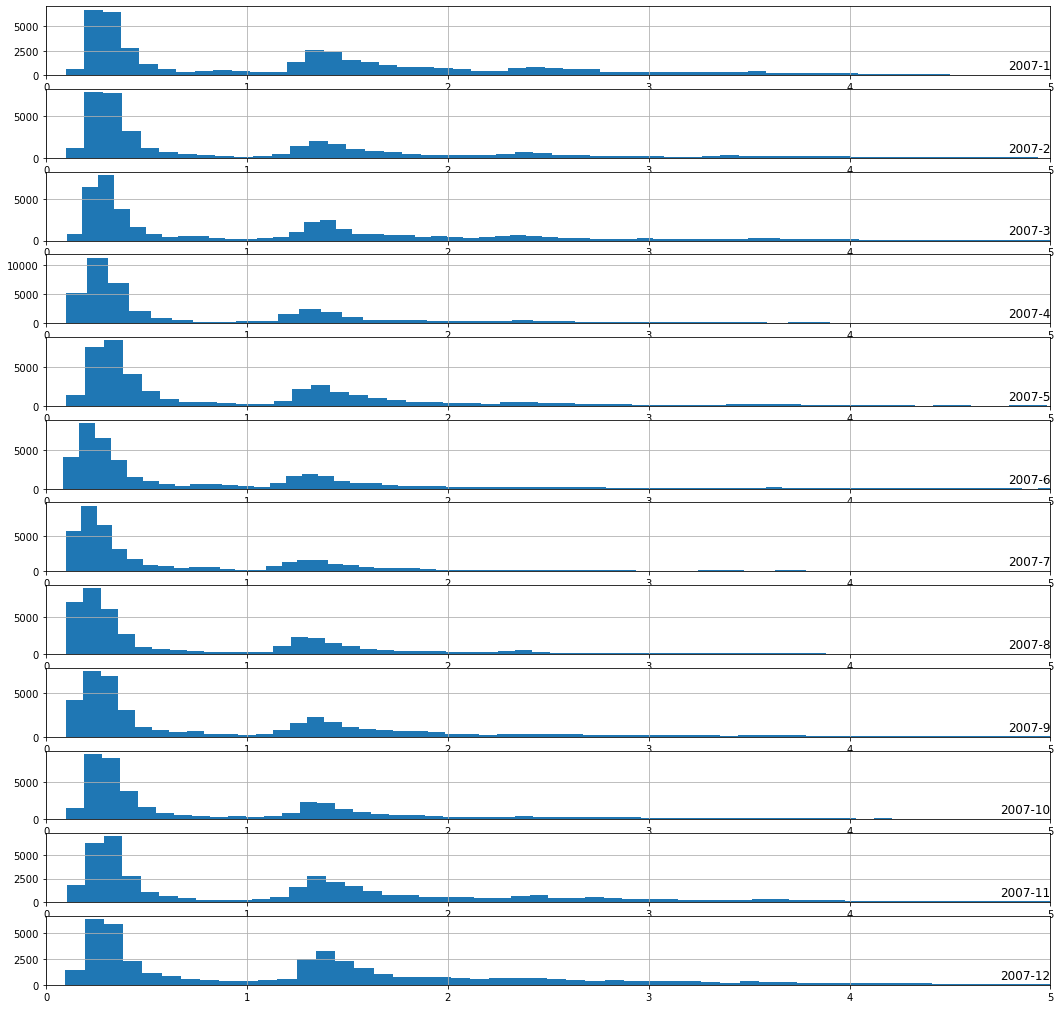

In [53]:
months = [i for i in range(1,13)]

fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    active_power_data = dataset[month]
    active_power_data['Global_active_power'].hist(bins = 100)
    ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
plt.show()
fig.tight_layout()

Observation :
1. From the above diagram we can say that power consumption in the month of Nov, Dec, Jan, Feb, Mar is more as there is a long tail as compare to other months.

2. It also shows that the during the winter seasons, the heating systems are used and not in summer.

3. The above graph is highly concentrated on 0.3W and 1.3W.

Active Power Uses Prediction
What can we predict
Forecast hourly consumption for the next day.
Forecast daily consumption for the next week.
Forecast daily consumption for the next month.
Forecast monthly consumption for the next year.
Modeling Methods
There are many modeling methods and few of those are as follows

Naive Methods -> Naive methods would include methods that make very simple, but often very effective assumptions.
Classical Linear Methods -> Classical linear methods include techniques are very effective for univariate time series forecasting
Machine Learning Methods -> Machine learning methods require that the problem be framed as a supervised learning problem.
K-nearest neighbors.
SVM
Decision trees
Random forest
Gradient boosting machines
Deep Learning Methods -> combinations of CNN LSTM and ConvLSTM, have proven effective on time series classification tasks
CNN
LSTM
CNN – LSTM
Problem Framing:
Given recent power consumption, what is the expected power consumption for the week ahead?
This requires that a predictive model forecast the total active power for each day over the next seven days

A model of this type could be helpful within the household in planning expenditures. It could also be helpful on the supply side for planning electricity demand for a specific household.

Input -> Predict

[Week1] -> Week2

[Week2] -> Week3

[Week3] -> Week4

In [54]:
#top rows

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [55]:
#printing last rows

data.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2010-12-07,1109.574,285.912,345914.85,4892.0,1724.0,646.0,6444.0
2010-12-08,529.698,169.098,346744.70,2338.2,0.0,514.0,3982.0
2010-12-09,1612.092,201.358,347932.40,6848.2,1805.0,2080.0,8891.0
2010-12-10,1579.692,170.268,345975.37,6741.2,1104.0,780.0,9812.0
2010-12-11,1836.822,151.144,343926.57,7826.2,2054.0,489.0,10308.0


In [56]:
#here are splitting the dataset
#dataset upto end of 2009 is in train dataset and remaining we keeping it in test dataset

data_train = data.loc[:'2009-12-31', :]['Global_active_power']
data_train.head()

date_time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [57]:
data_test = data['2010']['Global_active_power']
data_test.head()

date_time
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
Freq: D, Name: Global_active_power, dtype: float64

In [58]:
data_train.shape

(1112,)

In [59]:
data_test.shape

(345,)

In [60]:
#Prepare training data

In [61]:
#training data

data_train.head(14)

date_time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1723.288
2006-12-22    2341.338
2006-12-23    4773.386
2006-12-24    2550.012
2006-12-25    2743.120
2006-12-26    3934.110
2006-12-27    1528.760
2006-12-28    2072.638
2006-12-29    3174.392
Freq: D, Name: Global_active_power, dtype: float64

In [62]:
#converting the data into numpy array

data_train = np.array(data_train)

In [63]:
#we are splitting the data weekly wise(7days)

X_train, y_train = [], []

for i in range(7, len(data_train)-7):
    X_train.append(data_train[i-7:i])
    y_train.append(data_train[i:i+7])

In [64]:
#converting list to numpy array

X_train, y_train = np.array(X_train), np.array(y_train)

In [65]:
#shape of train and test dataset

X_train.shape, y_train.shape

((1098, 7), (1098, 7))

In [66]:
#printing the ytrain value

pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760


In [67]:
#Normalising the dataset between 0 and 1

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

In [68]:
#Normalising the dataset

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [69]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6
0,0.211996,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304
1,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000
2,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439
3,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133
4,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133,0.814446


In [70]:
#converting to 3 dimension

X_train = X_train.reshape(1098, 7, 1)

In [71]:
X_train.shape

(1098, 7, 1)

Build LSTM Model

In [72]:
#building sequential model using Keras

reg = Sequential()
reg.add(LSTM(units = 200, activation = 'relu', input_shape=(7,1)))
reg.add(Dense(7))

In [73]:
#here we have considered loss as mean square error and optimizer as adam

reg.compile(loss='mse', optimizer='adam') #regression h isme accuracy nhi mean squared error se accuracy dekhte

In [74]:
#training the model

reg.fit(X_train, y_train, epochs = 100)

Epoch 1/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0613
Epoch 2/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0247
Epoch 3/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0242
Epoch 4/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 5/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0239
Epoch 6/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0240
Epoch 7/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 8/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0239
Epoch 9/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0239
Epoch 10/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0243
Epoch 11/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0238
Epoch 12/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0238
Epoch 13/100
35/35 [=====

35/35 [==============================] - 0s 14ms/step - loss: 0.0228


In [75]:
#testing dataset

data_test = np.array(data_test)

In [76]:
#here we are splitting the data weekly wise(7days)

X_test, y_test = [], []

for i in range(7, len(data_test)-7):
    X_test.append(data_test[i-7:i])
    y_test.append(data_test[i:i+7])

In [77]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [78]:
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [79]:
#converting to 3 dimension

X_test = X_test.reshape(331,7,1)

In [80]:
y_pred = reg.predict(X_test)

In [81]:
#bringing y_pred values to their original forms by using inverse transform

y_pred = y_scaler.inverse_transform(y_pred)

In [82]:
y_pred

array([[1459.2955 , 1457.9275 , 1484.389  , ..., 1571.0404 , 1565.1093 ,
        1573.0042 ],
       [1142.7202 , 1261.941  , 1335.6196 , ..., 1518.1812 , 1509.2976 ,
        1499.3754 ],
       [1466.9762 , 1455.2875 , 1487.1348 , ..., 1523.0424 , 1498.304  ,
        1519.1776 ],
       ...,
       [1199.1943 , 1095.5101 , 1097.236  , ...,  923.06116,  734.0895 ,
         964.7293 ],
       [1614.7819 , 1454.7665 , 1319.1682 , ..., 1017.65576,  883.5166 ,
        1115.968  ],
       [1666.7015 , 1483.743  , 1326.9364 , ..., 1147.3362 , 1076.7573 ,
        1284.7349 ]], dtype=float32)

In [83]:
y_true = y_scaler.inverse_transform(y_test)

In [84]:
y_true

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

Evaluate the model
Here, we using metric as mean square error since it is a regression problem

In [85]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    #calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    #calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [86]:
evaluate_model(y_true, y_pred)

(578.3158041866303,
 [574.369814978207,
  584.735945372634,
  572.9732354233792,
  567.1018984280354,
  584.7467290986701,
  582.2771372787432,
  581.7637681515871])

In [87]:
#standard deviation

np.std(y_true[0])

710.0253857243853

Conclusions:
From the above experiment, we have got root mean square error around 598 watts.
In order to check whether our model is performing good or bad, we need to evaluate standard deviation which we have got here as 710 watts.
Here mean square error is less than standard deviation. Hence, we can say that our model is performing good.